In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
import torch

# VAE kernels
Can we use VAE as a kernel for convolutional layer? The idea is that for each receptive field, VAE would find multinomial gaussian distribution shared across all instances of the receptive field. The resulting system would have features, feature value ranges and distributions at each receptive field, similar to neurons with various feature value preferences for each receptive field in the cortex. For example, a neuron may have a preference for horizontal lines, upward movement, slow speed movement. That would be equivalent to VAE finding 3 features with specific values for a given receptive field. A neuron can have preference for only one (or few) values of a given feature so a lot of neurons are needed to represent the domain of each feature with sufficient statistical redundency. But a VAE's output for a given receptive field, e.g. 0.3 for feature 1, 0.9 for feature 2 and 0.5 for feature 3 with low, high and medium variance, respectively, can represent 1000s of feature-value preferences and 100s of neurons (because a neuron can be selective to a different value for each feature). The similifying factor here is Laplace assumption. Maybe using an order of magnitude more # of features would result at least in mixture of gaussians because a feature would get duplicated and learn different modes of the distribution.

## Basics

In [0]:
import logging
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(name)s:%(funcName)s %(levelname)s:%(message)s',
    datefmt="%M:%S")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

def show_image(image, vmin=None, vmax=None, title=None, print_values=False, figsize=(4, 4)):
  #print("image ", image.shape)
  image = image.cpu().numpy()
  fig, ax1 = plt.subplots(figsize=figsize)
  if title:
    plt.title(title)
  #i = image.reshape((height, width))
  #print("i ", i.shape)
  ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
  plt.show()
  if print_values:
    print(image)



## Network


In [0]:
class VAE(nn.Module):
  def __init__(self, input_width, input_height, feature_count):
    super(VAE, self).__init__()
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.WARN)

    self.feature_count = feature_count

    self.encoder = nn.Sequential(
      nn.Linear(input_width * input_height    , input_width * input_height * 2),
      nn.BatchNorm2d(1),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(input_width * input_height * 2, input_width * input_height * 4),
      nn.BatchNorm2d(1),
      nn.LeakyReLU(0.2, inplace=True),
    )

    self.decoder = nn.Sequential(
      nn.Linear(feature_count  , input_width * input_height * 2),
      nn.BatchNorm2d(1),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(input_width * input_height * 2, input_width * input_height),
      nn.BatchNorm2d(1),
      nn.Sigmoid(),
    )

    self.linear_mu = nn.Linear(input_width * input_height * 4, feature_count)
    self.linear_sigma = nn.Linear(input_width * input_height * 4, feature_count)

    self.lrelu = nn.LeakyReLU()
    self.relu = nn.ReLU()

  def encode(self, x):
    self.logger.debug(f"x {x.shape}")
    x = self.encoder(x)
    return self.linear_mu(x), self.linear_sigma(x)

  def decode(self, z):
    z = z.view(-1, 1, 1, self.feature_count)
    self.logger.debug(f"z {z.shape}")
    return self.decoder(z)

  def reparametrize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = torch.FloatTensor(std.size()).normal_().to(device)
    eps = eps.mul(std).add_(mu)
    eps = F.sigmoid(eps)
    self.logger.debug(f"eps {eps.shape}")

    return eps

  def forward(self, x):
    self.logger.debug(f"x {x.shape}")
    mu, logvar = self.encode(x)
    self.logger.debug(f"mu {mu.shape}")
    self.logger.debug(f"logvar {logvar.shape}")
    z = self.reparametrize(mu, logvar)
    self.logger.debug(f"z {z.shape}")
    decoded = self.decode(z)
    self.logger.debug(f"decoded {decoded.shape}")
    return decoded, mu, logvar, z
  
  
class Network(nn.Module):
  def __init__(self, input_width, input_height, feature_count):
    super(Network, self).__init__()
    self.input_width = input_width
    self.input_height = input_height
    self.vae = VAE(input_width, input_height, feature_count)
    
  def forward(self, x):
    return self.vae(x)

  def loss_function(self, recon_x, x, mu, logvar):
    # print(recon_x.size(), x.size())
    BCE = F.binary_cross_entropy(recon_x.view(-1, self.input_width * self.input_height), x.view(-1, self.input_width * self.input_height), size_average=True)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return BCE + KLD
    BCE /= 0.001
    #print(BCE, KLD)
    return BCE + 3 * KLD
  
  def train(self, input, num_epochs=3000):
    learning_rate = 10e-3
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate,
                                 weight_decay=1e-5)

    done = False
    epoch = 0
    while not done:
      output, mu, logvar, z = self(input)
      loss = self.loss_function(output, input, mu, logvar)
      # ===================backward====================
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if epoch % int(num_epochs / 10) == 0:
        print('epoch [{}/{}], loss:{:.4f}'
             .format(epoch+1, num_epochs, loss.item()))
        show_image(output[0, 0].view(self.input_height, self.input_width).detach(), title=f"output {0}", vmin=0, vmax=1)

      if (loss.item() < 0.001 and epoch > 1500) or epoch > num_epochs:
        done = True

      epoch += 1
      torch.save(self.state_dict(), self.save_path())

    return output, mu, logvar, z

  def save_path(self):
    return f"network.pt"




## Example

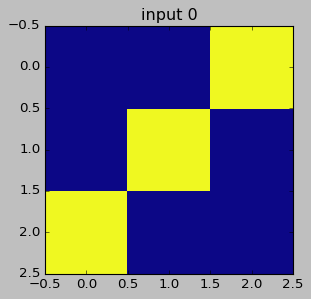

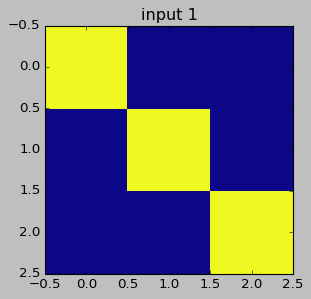

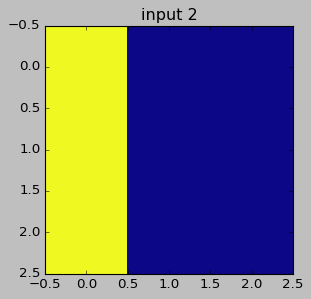

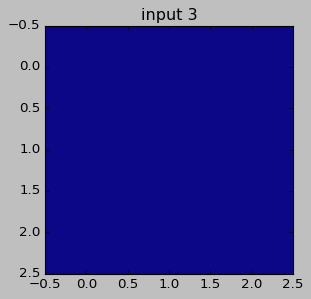

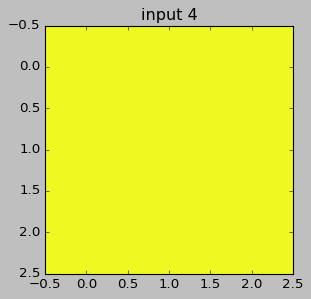

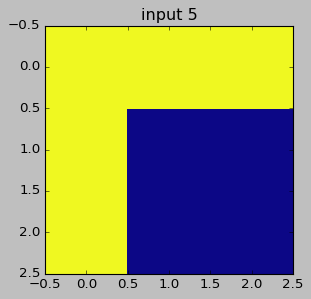

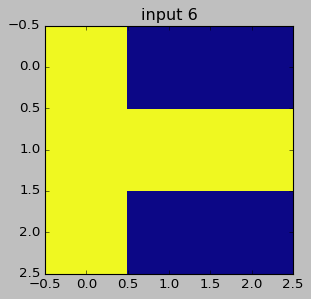

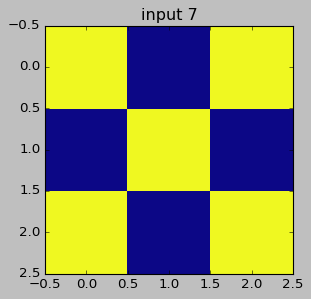

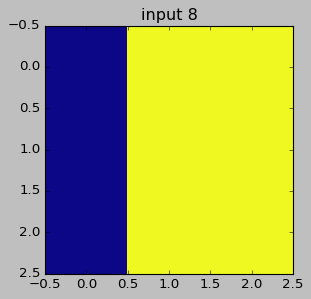

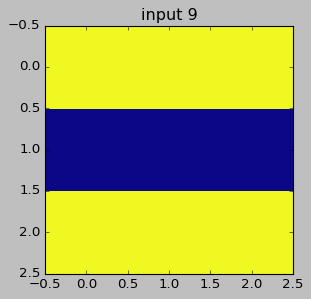

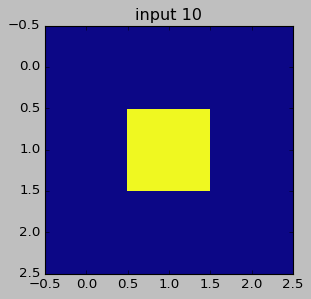

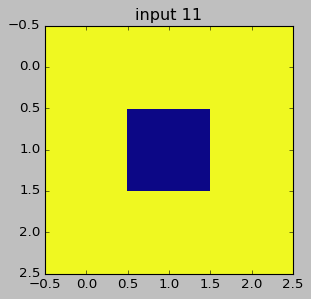

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


epoch [1/3000], loss:696.7103


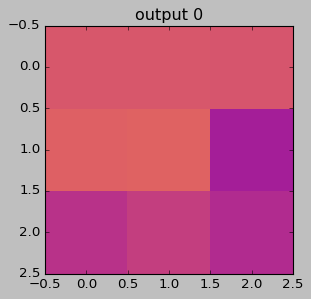

epoch [301/3000], loss:308.5131


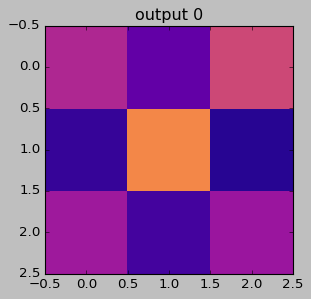

epoch [601/3000], loss:197.3381


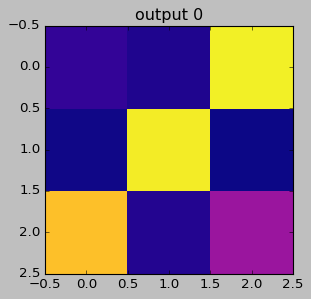

epoch [901/3000], loss:174.7145


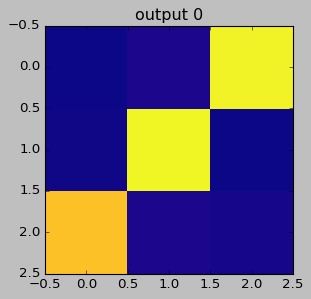

epoch [1201/3000], loss:164.4371


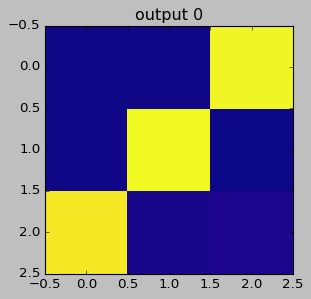

epoch [1501/3000], loss:191.2972


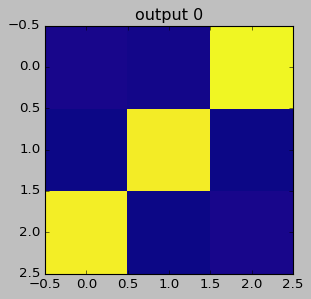

epoch [1801/3000], loss:154.0921


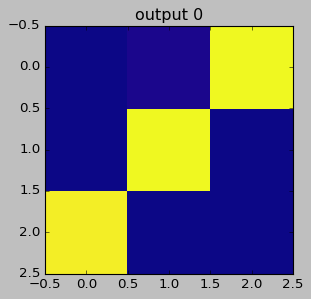

epoch [2101/3000], loss:178.9843


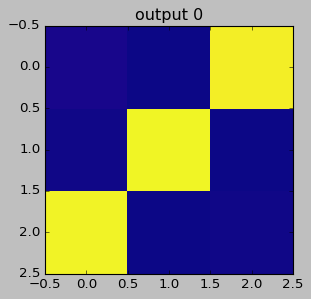

epoch [2401/3000], loss:180.2003


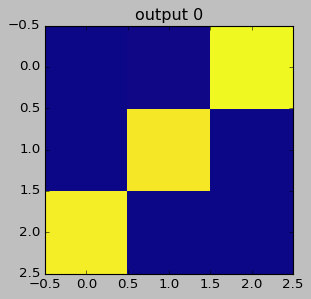

epoch [2701/3000], loss:142.0638


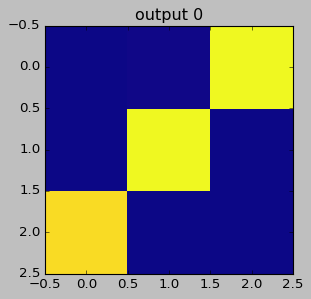

epoch [3001/3000], loss:184.8999


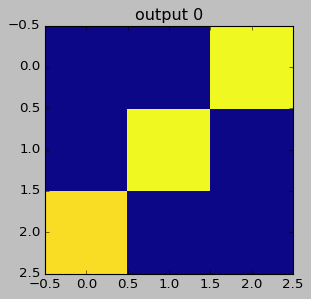

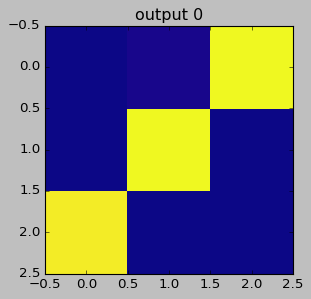

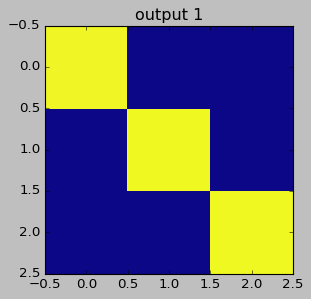

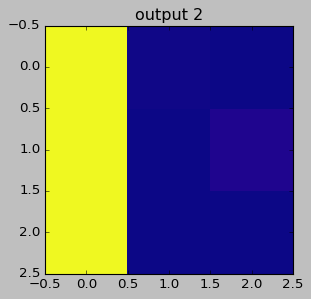

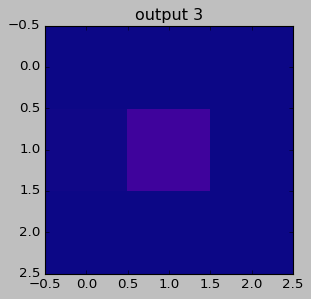

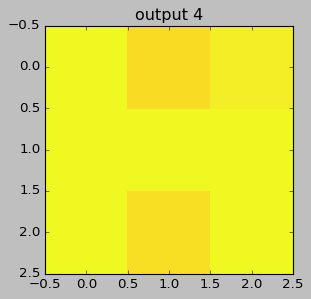

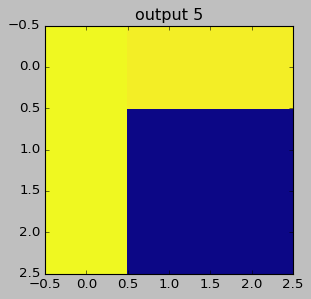

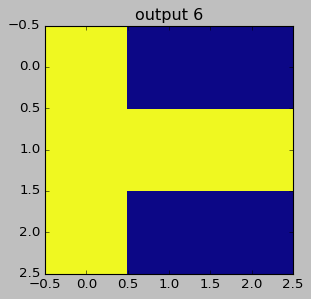

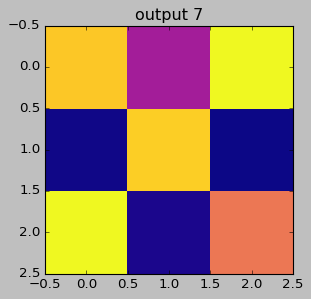

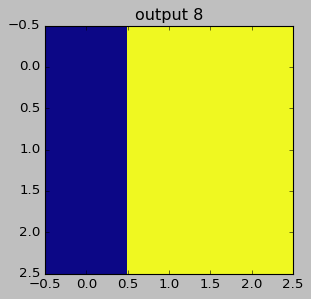

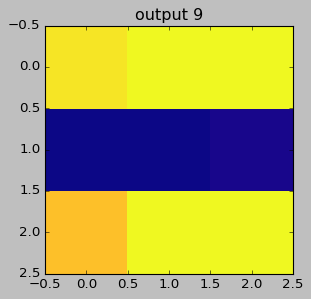

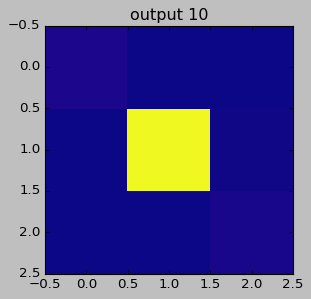

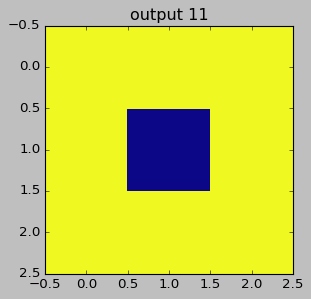

In [5]:
input_height = input_width = 3
input = [
  [0, 0, 1,
   0, 1, 0,
   1, 0, 0],
  [1, 0, 0,
   0, 1, 0,
   0, 0, 1],
  [1, 0, 0,
   1, 0, 0,
   1, 0, 0],
  [0, 0, 0,
   0, 0, 0,
   0, 0, 0],
  [1, 1, 1,
   1, 1, 1,
   1, 1, 1],
  [1, 1, 1,
   1, 0, 0,
   1, 0, 0],
  [1, 0, 0,
   1, 1, 1,
   1, 0, 0],
  [1, 0, 1,
   0, 1, 0,
   1, 0, 1],
  [0, 1, 1,
   0, 1, 1,
   0, 1, 1],
  [1, 1, 1,
   0, 0, 0,
   1, 1, 1],
  [0, 0, 0,
   0, 1, 0,
   0, 0, 0],
  [1, 1, 1,
   1, 0, 1,
   1, 1, 1],
]

feature_count = 4
input = torch.as_tensor(input).float().unsqueeze(dim=0).unsqueeze(dim=0).to(device)
image_count = input.shape[2]

for i in range(image_count):
  show_image(input[0,0,i].view(input_height, input_width), vmin=0, vmax=1, title=f"input {i}")

network = Network(input_height, input_width, feature_count).to(device)

decoded, mu, logvar, z = network.train(input)

for i in range(image_count):
  show_image(decoded[i,0,0].detach().view(input_height, input_width), vmin=0, vmax=1, title=f"output {i}")


In [0]:
# import os
# import glob

# files = glob.glob('./*.pt')
# for f in files:
#     os.remove(f)

tensor([[[[-0.1199,  1.1229,  1.2146, -0.0949],
          [ 0.1001,  1.2642, -1.4581, -0.4316],
          [ 0.0504, -0.9391,  0.1900, -1.3284],
          [ 0.0027,  0.3841,  1.0793, -1.7754],
          [-0.0455, -0.7376, -1.1372,  0.9601],
          [-0.1590, -1.1820,  1.0708, -0.3215],
          [-0.0360, -0.6005, -1.3248, -0.8998],
          [ 0.5438,  0.5684, -0.0825,  0.2999],
          [-1.4318,  1.2227, -0.1466,  1.9915],
          [ 0.2394, -0.4068,  1.5131,  1.0749],
          [-0.1714,  1.3321,  0.0356, -1.2441],
          [-0.1885, -1.5172, -0.0133,  1.0464]]]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[[[0.7774, 0.1268, 0.1434, 0.0269],
          [0.7067, 0.1185, 0.1431, 0.0613],
          [0.9520, 0.1207, 0.1097, 0.0764],
          [0.9648, 0.1134, 0.2127, 0.0996],
          [0.7475, 0.1145, 0.1467, 0.0608],
          [1.0899, 0.1621, 0.1708, 0.0396],
          [0.9171, 0.1157, 0.1232, 0.0806],
          [0.5704, 0.0843, 0.0931, 0.0299],
          [0.2360, 0.

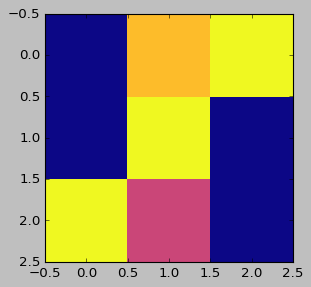

In [9]:
print(mu)
print(logvar.exp())
print(z)
decoded = network.vae.decode(torch.as_tensor(z[:,:,0:1,:]).to(device))
show_image(decoded[0,0,0].detach().view(input_height, input_width), vmin=0, vmax=1)

In [173]:
network.vae.reparametrize(mu, logvar)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[[[0.4025],
          [0.2565],
          [0.5588],
          [0.0625],
          [0.8068],
          [0.6130],
          [0.5147],
          [0.3319],
          [0.8556],
          [0.6801],
          [0.1534],
          [0.7478]]]], device='cuda:0', grad_fn=<SigmoidBackward>)